In [1]:
import numpy as np
import pandas as pd
from scipy import signal, fft
import matplotlib.pyplot as plt

In [2]:
def load(file, tnoise=200):
    # Load:
    x = pd.read_csv(file, header=None)
    x = x.values.reshape((x.size // 2, 2))
    x = pd.DataFrame(x, columns=["x", "t"])
    x = x.set_index("t")
    # Baseline center:
    xn = x.loc[x.index > tnoise, "x"].mean()
    x -= xn
    # Missing zero time:
    x.loc[0., "x"] = 0.
    x = x.sort_index()
    return x

https://en.wikipedia.org/wiki/Wiener_deconvolution

In [3]:
xraw = load("105rpm_dirac.data")
yraw = load("105rpm.data")

In [4]:
xraw

,x
t,
0.000,0.000000
0.195,0.000089
0.237,0.000081
0.302,0.000092
0.402,0.000074
...,...
239.635,-0.000004
239.750,-0.000005
239.802,-0.000006


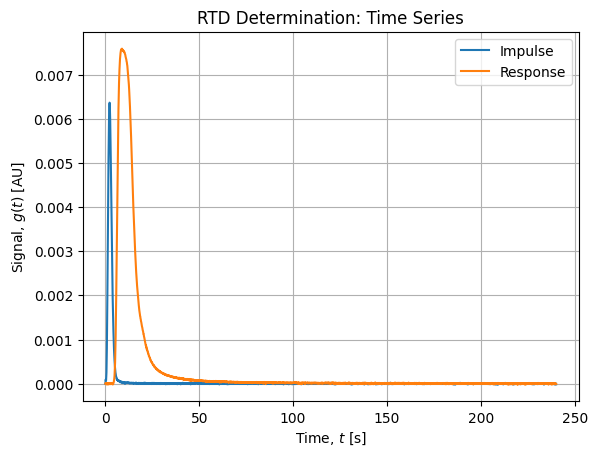

In [5]:
fig, axe = plt.subplots()
xraw.plot(ax=axe)
yraw.plot(ax=axe)
axe.set_title("RTD Determination: Time Series")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse", "Response"])
axe.grid()

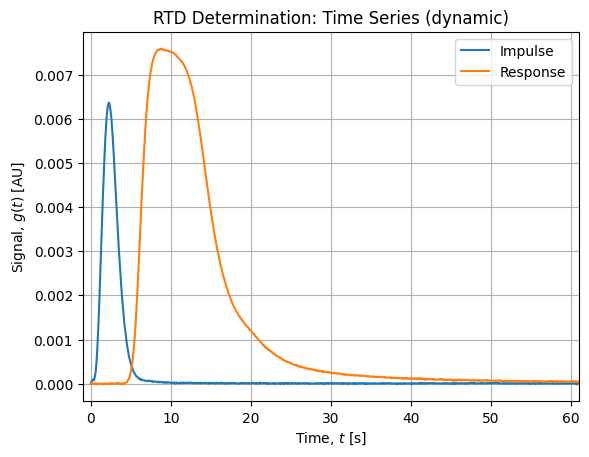

In [6]:
fig, axe = plt.subplots()
xraw.plot(ax=axe)
yraw.plot(ax=axe)
axe.set_xlim([-1, 61])
axe.set_title("RTD Determination: Time Series (dynamic)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse", "Response"])
axe.grid()

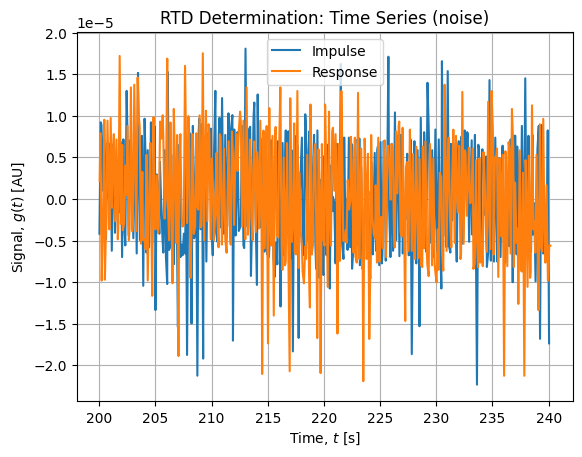

In [7]:
fig, axe = plt.subplots()
xraw.loc[xraw.index > 200, :].plot(ax=axe)
yraw.loc[yraw.index > 200, :].plot(ax=axe)
axe.set_title("RTD Determination: Time Series (noise)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse", "Response"])
axe.grid()

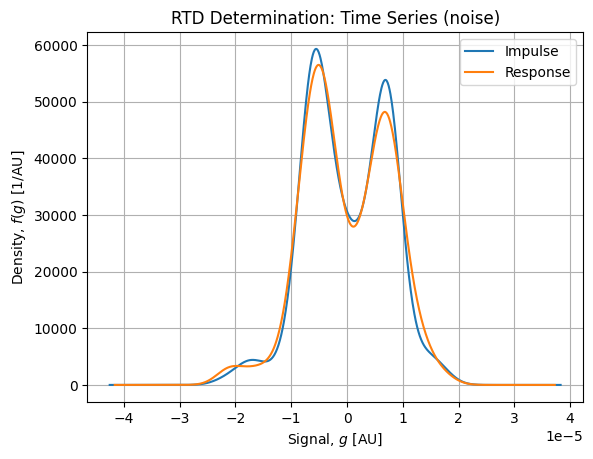

In [8]:
fig, axe = plt.subplots()
xraw.loc[xraw.index > 200, "x"].plot(kind="kde", ax=axe)
yraw.loc[yraw.index > 200, "x"].plot(kind="kde", ax=axe)
axe.set_title("RTD Determination: Time Series (noise)")
axe.set_xlabel("Signal, $g$ [AU]")
axe.set_ylabel("Density, $f(g)$ [1/AU]")
axe.legend(["Impulse", "Response"])
axe.grid()

In [9]:
def resample(x, space):
    idx = list(sorted(set(x.index) | set(space)))
    xnew = x.reindex(idx).interpolate()
    return xnew.loc[space, :]

In [10]:
t = np.arange(0, 240.01, 0.005)
dt = np.diff(t)[0]
fs = 1/dt

In [11]:
xr = resample(xraw, t)
yr = resample(yraw, t)

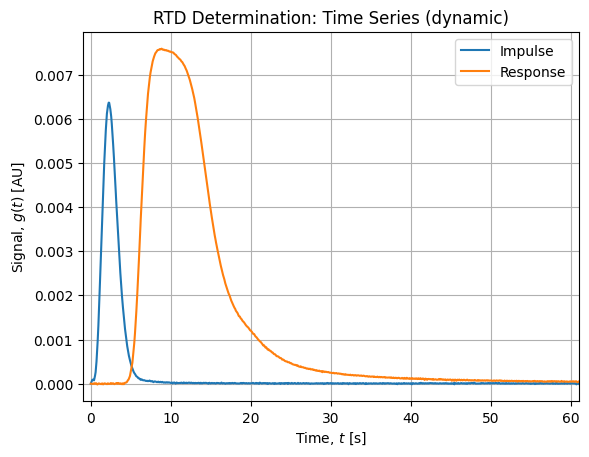

In [12]:
fig, axe = plt.subplots()
xr.plot(ax=axe)
yr.plot(ax=axe)
axe.set_xlim([-1, 61])
axe.set_title("RTD Determination: Time Series (dynamic)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse", "Response"])
axe.grid()

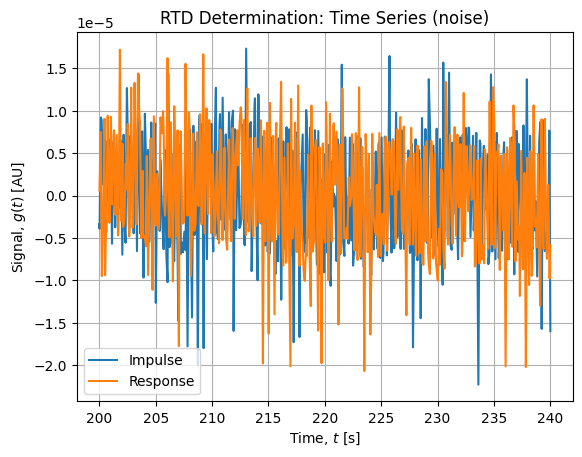

In [13]:
fig, axe = plt.subplots()
xr.loc[xr.index > 200, :].plot(ax=axe)
yr.loc[yr.index > 200, :].plot(ax=axe)
axe.set_title("RTD Determination: Time Series (noise)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse", "Response"])
axe.grid()

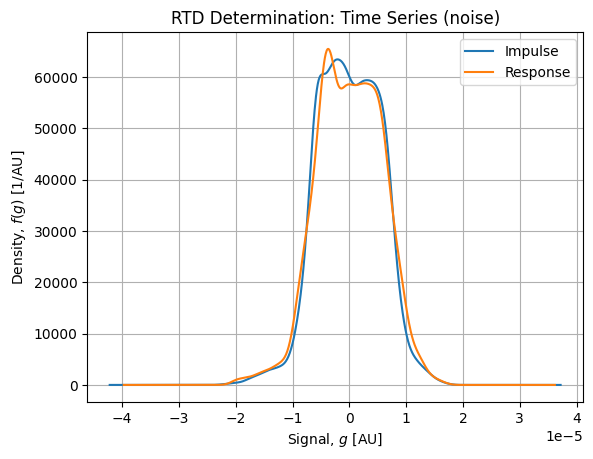

In [14]:
fig, axe = plt.subplots()
xr.loc[xr.index > 200, "x"].plot(kind="kde", ax=axe)
yr.loc[yr.index > 200, "x"].plot(kind="kde", ax=axe)
axe.set_title("RTD Determination: Time Series (noise)")
axe.set_xlabel("Signal, $g$ [AU]")
axe.set_ylabel("Density, $f(g)$ [1/AU]")
axe.legend(["Impulse", "Response"])
axe.grid()

In [15]:
def smooth(x, size=4*60, order=3, dt=dt):
    x["xs"] = signal.savgol_filter(x["x"].values, size, order, mode="nearest")
    x["dxsdt"] = signal.savgol_filter(x["x"].values, size, order, mode="nearest", delta=dt, deriv=1)
    x["dx"] = x["x"] - x["xs"]
    x["rdx"] = x["dx"]/x["xs"]
    x["xs_"] = x["xs"]
    return x

In [16]:
xs = smooth(xr)
ys = smooth(yr)

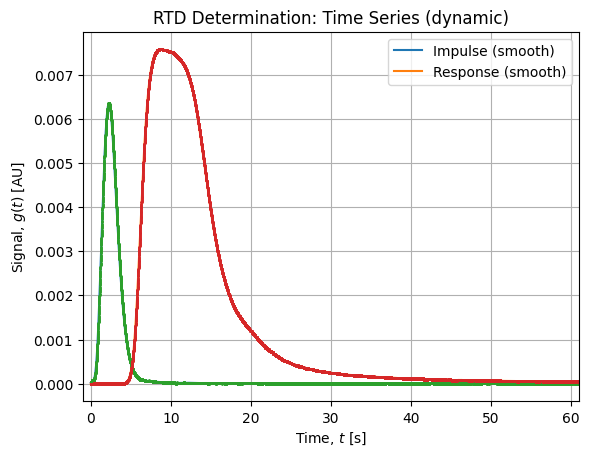

In [17]:
fig, axe = plt.subplots()
xs["xs"].plot(ax=axe)
ys["xs"].plot(ax=axe)
xs["x"].plot(linestyle="none", marker=".", markersize=2, ax=axe)
ys["x"].plot(linestyle="none", marker=".", markersize=2, ax=axe)
axe.set_xlim([-1, 61])
axe.set_title("RTD Determination: Time Series (dynamic)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse (smooth)", "Response (smooth)"])
axe.grid()

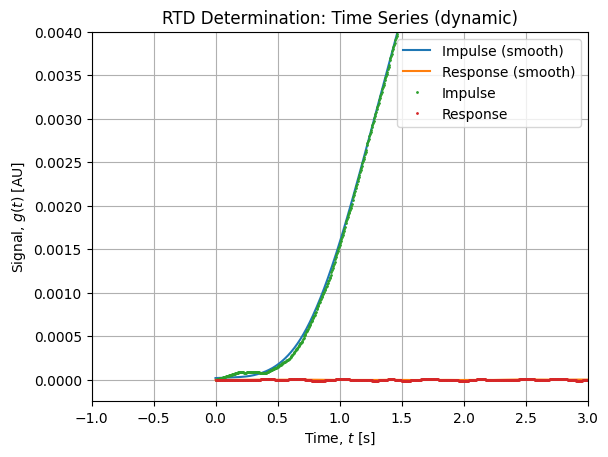

In [18]:
fig, axe = plt.subplots()
xs["xs"].plot(ax=axe)
ys["xs"].plot(ax=axe)
xs["x"].plot(linestyle="none", marker=".", markersize=2, ax=axe)
ys["x"].plot(linestyle="none", marker=".", markersize=2, ax=axe)
axe.set_title("RTD Determination: Time Series (dynamic)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse (smooth)", "Response (smooth)", "Impulse", "Response", ])
axe.set_xlim([-1, 3])
axe.set_ylim([-0.00025, 0.004])
axe.grid()

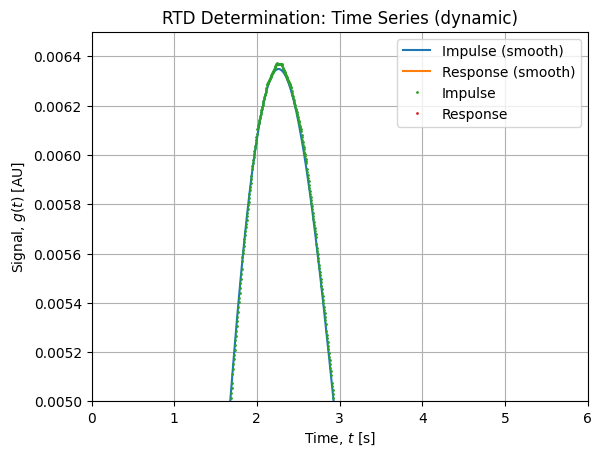

In [19]:
fig, axe = plt.subplots()
xs["xs"].plot(ax=axe)
ys["xs"].plot(ax=axe)
xs["x"].plot(linestyle="none", marker=".", markersize=2, ax=axe)
ys["x"].plot(linestyle="none", marker=".", markersize=2, ax=axe)
axe.set_title("RTD Determination: Time Series (dynamic)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse (smooth)", "Response (smooth)", "Impulse", "Response", ])
axe.set_xlim([0, 6])
axe.set_ylim([0.005, 0.0065])
axe.grid()

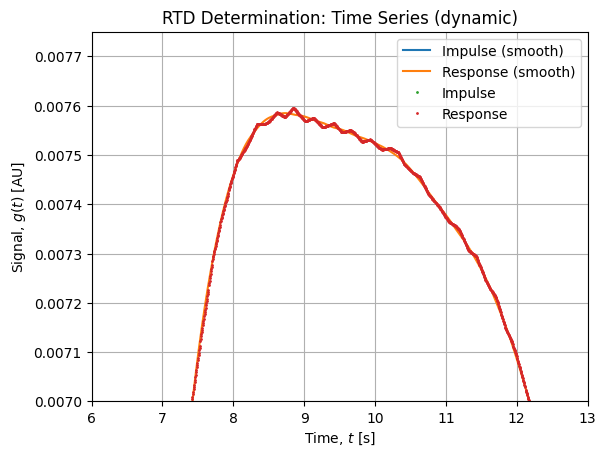

In [20]:
fig, axe = plt.subplots()
xs["xs"].plot(ax=axe)
ys["xs"].plot(ax=axe)
xs["x"].plot(linestyle="none", marker=".", markersize=2, ax=axe)
ys["x"].plot(linestyle="none", marker=".", markersize=2, ax=axe)
axe.set_title("RTD Determination: Time Series (dynamic)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse (smooth)", "Response (smooth)", "Impulse", "Response", ])
axe.set_xlim([6, 13])
axe.set_ylim([0.007, 0.00775])
axe.grid()

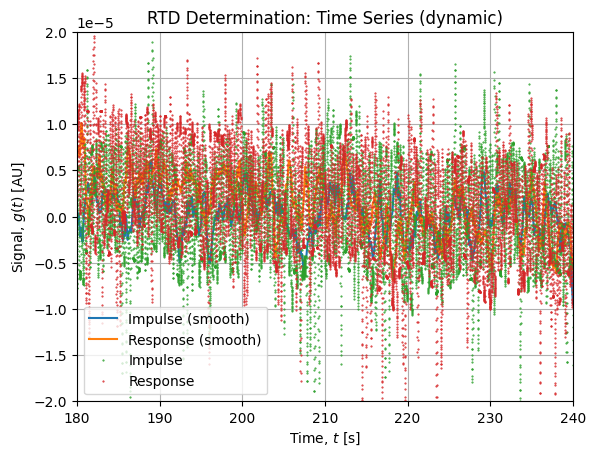

In [21]:
fig, axe = plt.subplots()
xs["xs"].plot(ax=axe)
ys["xs"].plot(ax=axe)
xs["x"].plot(linestyle="none", marker=".", markersize=1, ax=axe)
ys["x"].plot(linestyle="none", marker=".", markersize=1, ax=axe)
axe.set_title("RTD Determination: Time Series (dynamic)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse (smooth)", "Response (smooth)", "Impulse", "Response",])
axe.set_xlim([180, 240])
axe.set_ylim([-2e-5, 2e-5])
axe.grid()

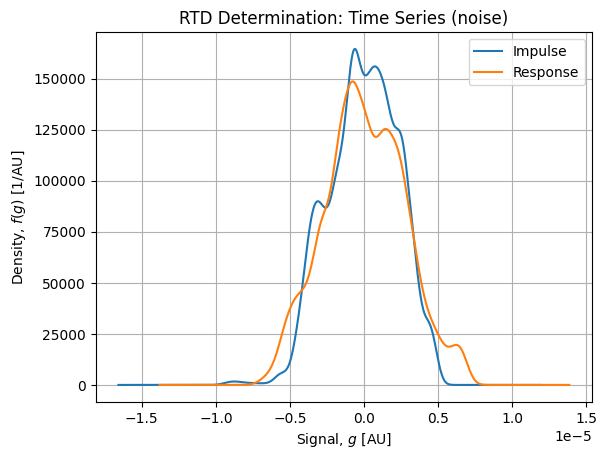

In [22]:
fig, axe = plt.subplots()
xs.loc[xs.index > 200, "xs"].plot(kind="kde", ax=axe)
ys.loc[ys.index > 200, "xs"].plot(kind="kde", ax=axe)
axe.set_title("RTD Determination: Time Series (noise)")
axe.set_xlabel("Signal, $g$ [AU]")
axe.set_ylabel("Density, $f(g)$ [1/AU]")
axe.legend(["Impulse", "Response"])
axe.grid()

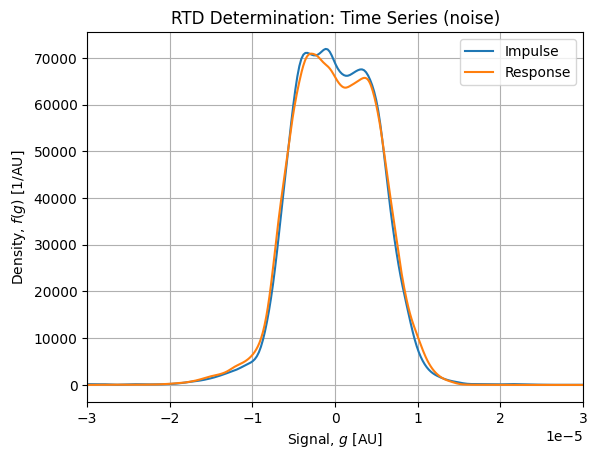

In [23]:
fig, axe = plt.subplots()
xs.loc[:, "dx"].plot(kind="kde", ax=axe)
ys.loc[:, "dx"].plot(kind="kde", ax=axe)
axe.set_title("RTD Determination: Time Series (noise)")
axe.set_xlabel("Signal, $g$ [AU]")
axe.set_ylabel("Density, $f(g)$ [1/AU]")
axe.set_xlim([-3e-5, 3e-5])
axe.legend(["Impulse", "Response"])
axe.grid()

In [276]:
xi = slice(0, 120)
yi = slice(3.8, 123.8)
ni = slice(180, 240)

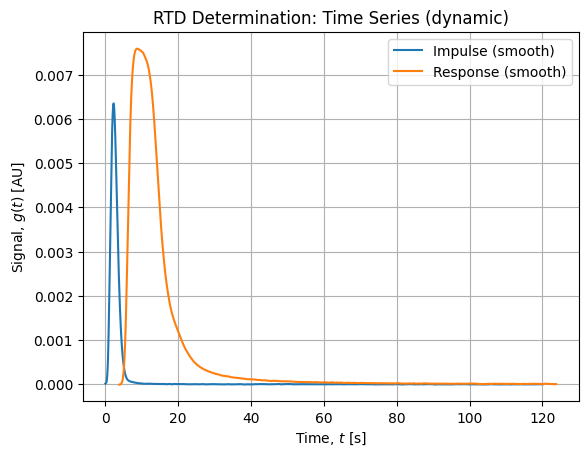

In [278]:
fig, axe = plt.subplots()
xs.loc[xi, "xs"].plot(ax=axe)
ys.loc[yi, "xs"].plot(ax=axe)
axe.set_title("RTD Determination: Time Series (dynamic)")
axe.set_xlabel("Time, $t$ [s]")
axe.set_ylabel("Signal, $g(t)$ [AU]")
axe.legend(["Impulse (smooth)", "Response (smooth)"])
axe.grid()

In [279]:
x = xs.loc[xi, "xs"].values
y = ys.loc[yi, "xs"].values
n = ys.loc[ni, "xs"].values

In [280]:
N = 2**12
N

4096

In [281]:
f = window = signal.windows.chebwin(20, at=80)
F = fft.fft(f, n=N)/(len(f)/2.0)

/home/jlandercy/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


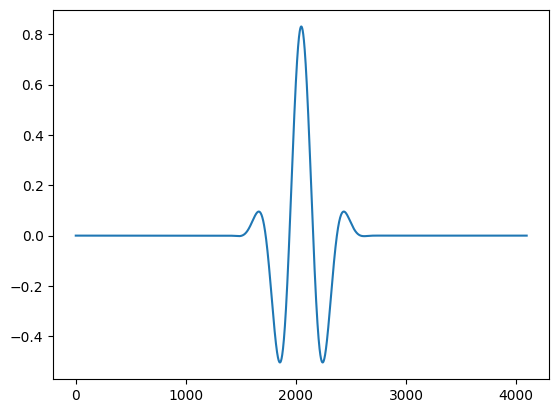

In [282]:
plt.plot(fft.fftshift(F))

In [283]:
X = fft.fft(x, n=N)*F
Y = fft.fft(y, n=N)*F
w = fft.fftfreq(d=dt, n=N)

In [284]:
x_ = np.real(fft.ifft(X))
y_ = np.real(fft.ifft(Y))

In [285]:
fx, Px = signal.welch(x_, fs=fs, nfft=N, return_onesided=False)
fy, Py = signal.welch(y_, fs=fs, nfft=N, return_onesided=False)
fn, Pn = signal.welch(n, fs=fs, nfft=N, return_onesided=False)

In [286]:
fx_, Px_ = signal.welch(x_, fs=fs, nfft=N)
fy_, Py_ = signal.welch(y_, fs=fs, nfft=N)
fn_, Pn_ = signal.welch(n, fs=fs, nfft=N)

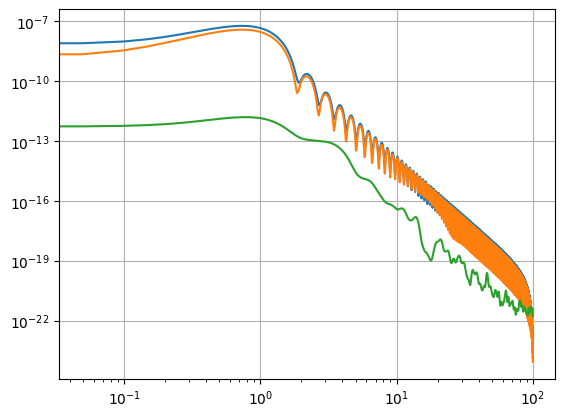

In [287]:
fig, axe = plt.subplots()
axe.loglog(fx_, Px_)
axe.loglog(fy_, Py_)
axe.loglog(fn_, Pn_)
axe.grid()

In [266]:
#Pn = np.sqrt(Pn)

In [329]:
G = (Y*Px)/((Y*Y.conj())*Px + Pn + 2e-3)

In [346]:
#g -= g.min()

In [347]:
#g -= 0.5e-8
#g[g<0] = 0

In [408]:
g = np.real(fft.ifft(G))

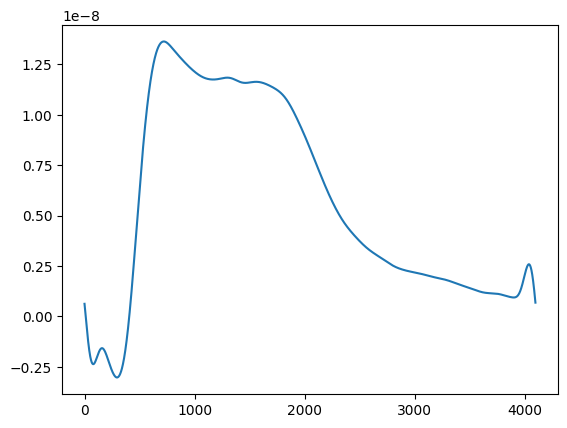

In [409]:
fig, axe = plt.subplots()
axe.plot(g)
#axe.plot(g[400:-180])

In [412]:
yc = signal.convolve(g[400:-300], xs.loc[0:10, "xs"].values)
yc = signal.convolve(g, xs.loc[0:10, "xs"].values)
yc /= (yc.max() - yc.min())
yc *= 0.008
#yc /= 130

(0.0, 10000.0)

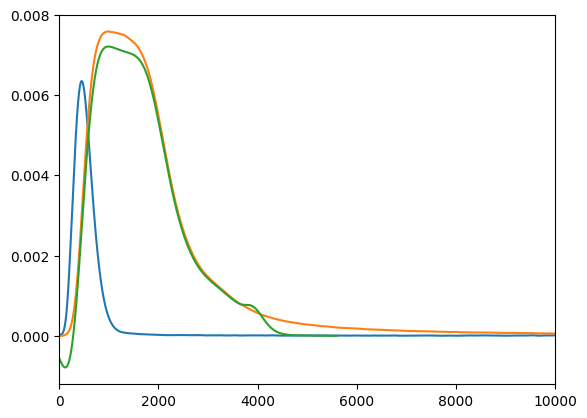

In [413]:
fig, axe = plt.subplots()
axe.plot(x)
axe.plot(y)
#axe.plot(g*1e5)
axe.plot(yc[500:])
axe.set_xlim([0, 10000])